In [1]:
import pickle
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from model import CNNModel, XGBPipeline
from preprocessing import Splitter
from cfg import *

In [2]:
with open("./data/raw/covid_flow.pkl", 'rb') as data_file:
    data = pickle.load(data_file)

In [3]:
for column in data.columns:
    if column.endswith("_dinam_fact"):
        print(column)

Температура_dinam_fact
Лимфоциты#_dinam_fact
АСТ_dinam_fact
ЧСС_dinam_fact
ЧДД_dinam_fact
Билирубин общий_dinam_fact
MPV- Средн.объем тромбоцитов_dinam_fact
PCT- Тромбокрит_dinam_fact
Лимфоциты%_dinam_fact
снижение_сознания_dinam_fact
Cтепень тяжести по КТ_dinam_fact
Лактатдегидрогеназа_dinam_fact
PDW- Индекс расп.по объему тр._dinam_fact


In [4]:
for column in data.columns:
    if column.endswith("_dinam_control"):
        print(column)

трансфузия_dinam_control
оксигенотерапия_dinam_control
НИВЛ_dinam_control
ИВЛ_dinam_control


In [5]:
for column in data.columns:
    if column.endswith("_dinam_fact"):
        print(column)

Температура_dinam_fact
Лимфоциты#_dinam_fact
АСТ_dinam_fact
ЧСС_dinam_fact
ЧДД_dinam_fact
Билирубин общий_dinam_fact
MPV- Средн.объем тромбоцитов_dinam_fact
PCT- Тромбокрит_dinam_fact
Лимфоциты%_dinam_fact
снижение_сознания_dinam_fact
Cтепень тяжести по КТ_dinam_fact
Лактатдегидрогеназа_dinam_fact
PDW- Индекс расп.по объему тр._dinam_fact


In [6]:
target_columns = []
for column in data:
    if DINAM_CONTROL_PREFIX in column:
        target_columns.append(column)
target_columns

['трансфузия_dinam_control',
 'оксигенотерапия_dinam_control',
 'НИВЛ_dinam_control',
 'ИВЛ_dinam_control']

In [7]:
feat_columns = []
for column in data:
    if DINAM_CONTROL_PREFIX not in  column and (
        STAT_CONTROL_PREFIX in column
        or STAT_FACT_PREFIX in  column
        or DINAM_FACT_PREFIX in column
    ):
        feat_columns.append(column)

feat_columns

['омепразол_stat_control',
 'надропарин кальция_stat_control',
 'эзомепразол_stat_control',
 'амлодипин_stat_control',
 'амброксол_stat_control',
 'домперидон_stat_control',
 'меброфенин_stat_control',
 'технеций_stat_control',
 'мометазон_stat_control',
 'бисопролол_stat_control',
 'дексаметазон_stat_control',
 'гидрохлоротиазид_stat_control',
 'гидроксихлорохин_stat_control',
 'рабепразол_stat_control',
 'эноксапарин натрия_stat_control',
 'периндоприл_stat_control',
 'ацетилцистеин_stat_control',
 'азитромицин_stat_control',
 'валсартан_stat_control',
 'метилпреднизолон_stat_control',
 'лоратадин_stat_control',
 'хлорохин_stat_control',
 'натрия хлорид_stat_control',
 'индапамид_stat_control',
 'преднизолон_stat_control',
 'аторвастатин_stat_control',
 'декстран_stat_control',
 'лизиноприл_stat_control',
 'лозартан_stat_control',
 'Температура_dinam_fact',
 'Лимфоциты#_dinam_fact',
 'АСТ_dinam_fact',
 'ЧСС_dinam_fact',
 'ЧДД_dinam_fact',
 'Билирубин общий_dinam_fact',
 'MPV- Средн.о

In [8]:
splitter = Splitter(train_size=0.8, target_columns=target_columns, random_state=21)
train, test = splitter.get_split(data)

splitter = Splitter(train_size=0.5, random_state=21)
test, val = splitter.get_split(test)

print(train.shape)
print(test.shape)
print(val.shape)

(559, 54)
(83, 54)
(71, 54)


In [9]:
dinam_fact_columns = []
for column in data.columns:
    if DINAM_FACT_PREFIX in column:
        dinam_fact_columns.append(column)
dinam_fact_columns

['Температура_dinam_fact',
 'Лимфоциты#_dinam_fact',
 'АСТ_dinam_fact',
 'ЧСС_dinam_fact',
 'ЧДД_dinam_fact',
 'Билирубин общий_dinam_fact',
 'MPV- Средн.объем тромбоцитов_dinam_fact',
 'PCT- Тромбокрит_dinam_fact',
 'Лимфоциты%_dinam_fact',
 'снижение_сознания_dinam_fact',
 'Cтепень тяжести по КТ_dinam_fact',
 'Лактатдегидрогеназа_dinam_fact',
 'PDW- Индекс расп.по объему тр._dinam_fact']

In [10]:
xgb_pipe = XGBPipeline(dinam_fact_columns)
xgb_pipe.fit(
    train[feat_columns],
    train[target_columns],
    (val[feat_columns], val[target_columns]),
    #early_stopping_rounds=30,
    verbose=500
)

[0]	validation_0-logloss:0.69272
[500]	validation_0-logloss:0.55003
[1000]	validation_0-logloss:0.48779
[1500]	validation_0-logloss:0.45849
[2000]	validation_0-logloss:0.44458
[2500]	validation_0-logloss:0.43795
[2635]	validation_0-logloss:0.43752


In [11]:
prediction = xgb_pipe.predict(test[feat_columns])
prediction.shape

(83, 4)

In [12]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score

print(f'{target_columns[3]} - {accuracy_score(test[target_columns].values[:, 3], prediction[:, 3])}')
print(f'{target_columns[2]} - {accuracy_score(test[target_columns].values[:, 2], prediction[:, 2])}')
print(f'{target_columns[1]} - {accuracy_score(test[target_columns].values[:, 1], prediction[:, 1])}')
print(f'{target_columns[0]} - {accuracy_score(test[target_columns].values[:, 0], prediction[:, 0])}')
print()

print(f'{target_columns[3]} - \n{confusion_matrix(test[target_columns].values[:, 3], prediction[:, 3])}')
print(f'{target_columns[2]} - \n{confusion_matrix(test[target_columns].values[:, 2], prediction[:, 2])}')
print(f'{target_columns[1]} - \n{confusion_matrix(test[target_columns].values[:, 1], prediction[:, 1])}')
print(f'{target_columns[0]} - \n{confusion_matrix(test[target_columns].values[:, 0], prediction[:, 0])}')
print()

print(f'{target_columns[3]} - {f1_score(test[target_columns].values[:, 3], prediction[:, 3])}')
print(f'{target_columns[2]} - {f1_score(test[target_columns].values[:, 2], prediction[:, 2])}')
print(f'{target_columns[1]} - {f1_score(test[target_columns].values[:, 1], prediction[:, 1])}')
print(f'{target_columns[0]} - {f1_score(test[target_columns].values[:, 0], prediction[:, 0])}')

ИВЛ_dinam_control - 0.7951807228915663
НИВЛ_dinam_control - 0.8313253012048193
оксигенотерапия_dinam_control - 0.8072289156626506
трансфузия_dinam_control - 0.8192771084337349

ИВЛ_dinam_control - 
[[47  6]
 [11 19]]
НИВЛ_dinam_control - 
[[69  0]
 [14  0]]
оксигенотерапия_dinam_control - 
[[29 12]
 [ 4 38]]
трансфузия_dinam_control - 
[[66  2]
 [13  2]]

ИВЛ_dinam_control - 0.6909090909090909
НИВЛ_dinam_control - 0.0
оксигенотерапия_dinam_control - 0.8260869565217391
трансфузия_dinam_control - 0.2105263157894737


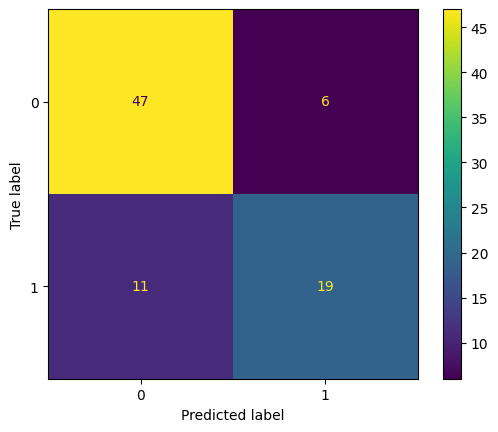

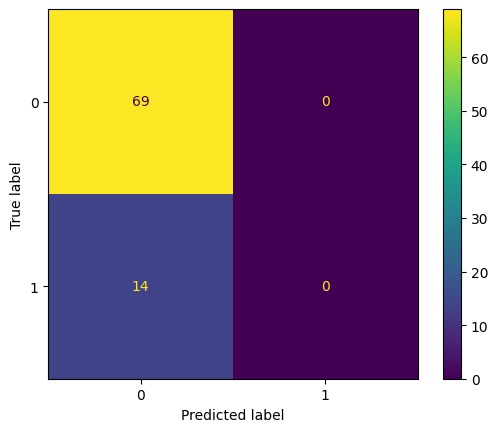

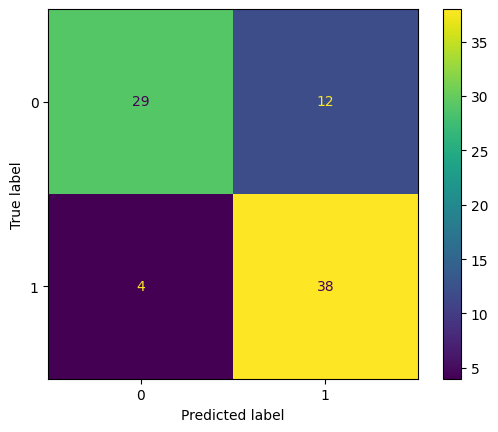

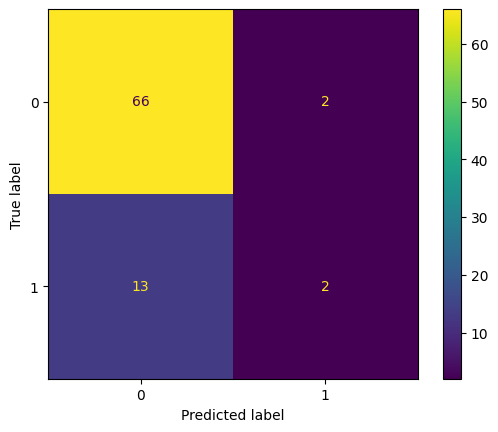

In [13]:
ConfusionMatrixDisplay(confusion_matrix(test[target_columns].values[:, 3], prediction[:, 3])).plot()
ConfusionMatrixDisplay(confusion_matrix(test[target_columns].values[:, 2], prediction[:, 2])).plot()
ConfusionMatrixDisplay(confusion_matrix(test[target_columns].values[:, 1], prediction[:, 1])).plot()
ConfusionMatrixDisplay(confusion_matrix(test[target_columns].values[:, 0], prediction[:, 0])).plot()
plt.show()

In [14]:
target = []
eval_target = []

encoder = OneHotEncoder(sparse=False)

for index in range(0, train[target_columns].shape[1]):
    target.append(encoder.fit_transform(train[target_columns].iloc[:, index].values.reshape(-1, 1)))
print(np.array(target).shape)

for index in range(0, val[target_columns].shape[1]):
    eval_target.append(encoder.transform(val[target_columns].iloc[:, index].values.reshape(-1, 1)))
print(np.array(eval_target).shape)

(4, 559, 2)
(4, 71, 2)


In [15]:

test_model = CNNModel(
    num_binary_classes=4,
    dynamic_columns=dinam_fact_columns,
    window_size=4
)

test_model.fit(
    train[feat_columns],
    target,
    epochs=40,
    eval_data=(val[feat_columns], eval_target),
    learning_rate=0.001
)

Epoch 1/40
18/18 [==============================] - 1s 59ms/step - loss: 2.4307 - out_0_loss: 0.5539 - out_1_loss: 0.7063 - out_2_loss: 0.5189 - out_3_loss: 0.6515 - out_0_get_f1: 0.7775 - out_1_get_f1: 0.5045 - out_2_get_f1: 0.7999 - out_3_get_f1: 0.6484 - val_loss: 2.1937 - val_out_0_loss: 0.4566 - val_out_1_loss: 0.7086 - val_out_2_loss: 0.3975 - val_out_3_loss: 0.6309 - val_out_0_get_f1: 0.7961 - val_out_1_get_f1: 0.4345 - val_out_2_get_f1: 0.8527 - val_out_3_get_f1: 0.7128

In [16]:
prediction = test_model.predict(test[feat_columns])
prediction.shape

(4, 83)

In [17]:
print(f'{target_columns[3]} - {accuracy_score(test[target_columns].values[:, 3], prediction[3])}')
print(f'{target_columns[2]} - {accuracy_score(test[target_columns].values[:, 2], prediction[2])}')
print(f'{target_columns[1]} - {accuracy_score(test[target_columns].values[:, 1], prediction[1])}')
print(f'{target_columns[0]} - {accuracy_score(test[target_columns].values[:, 0], prediction[0])}')
print()

print(f'{target_columns[3]} - \n{confusion_matrix(test[target_columns].values[:, 3], prediction[3])}')
print(f'{target_columns[2]} - \n{confusion_matrix(test[target_columns].values[:, 2], prediction[2])}')
print(f'{target_columns[1]} - \n{confusion_matrix(test[target_columns].values[:, 1], prediction[1])}')
print(f'{target_columns[0]} - \n{confusion_matrix(test[target_columns].values[:, 0], prediction[0])}')
print()

print(f'{target_columns[3]} - {f1_score(test[target_columns].values[:, 3], prediction[3])}')
print(f'{target_columns[2]} - {f1_score(test[target_columns].values[:, 2], prediction[2])}')
print(f'{target_columns[1]} - {f1_score(test[target_columns].values[:, 1], prediction[1])}')
print(f'{target_columns[0]} - {f1_score(test[target_columns].values[:, 0], prediction[0])}')

ИВЛ_dinam_control - 0.6867469879518072
НИВЛ_dinam_control - 0.8313253012048193
оксигенотерапия_dinam_control - 0.6987951807228916
трансфузия_dinam_control - 0.8192771084337349

ИВЛ_dinam_control - 
[[47  6]
 [20 10]]
НИВЛ_dinam_control - 
[[69  0]
 [14  0]]
оксигенотерапия_dinam_control - 
[[33  8]
 [17 25]]
трансфузия_dinam_control - 
[[68  0]
 [15  0]]

ИВЛ_dinam_control - 0.43478260869565216
НИВЛ_dinam_control - 0.0
оксигенотерапия_dinam_control - 0.6666666666666667
трансфузия_dinam_control - 0.0


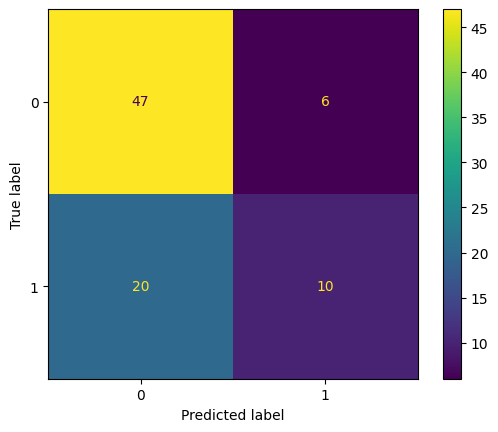

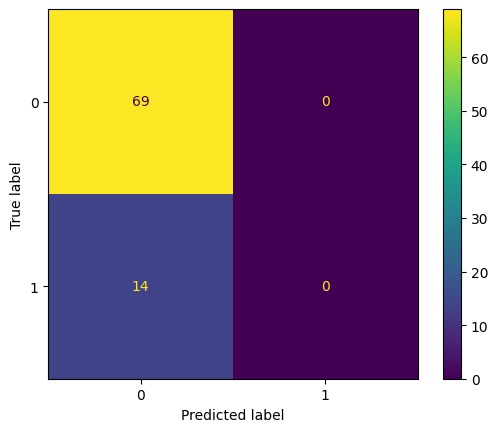

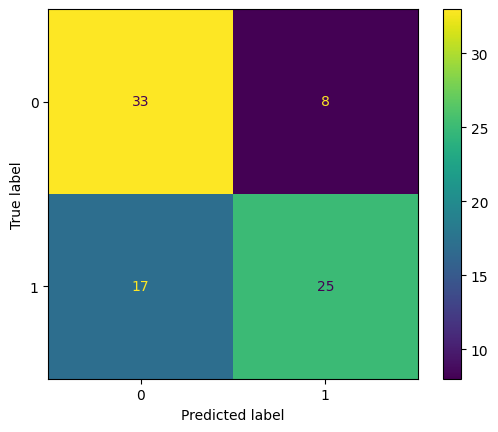

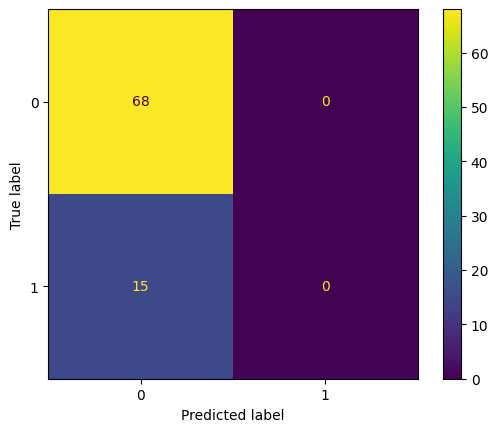

In [18]:
ConfusionMatrixDisplay(confusion_matrix(test[target_columns].values[:, 3], prediction[3])).plot()
ConfusionMatrixDisplay(confusion_matrix(test[target_columns].values[:, 2], prediction[2])).plot()
ConfusionMatrixDisplay(confusion_matrix(test[target_columns].values[:, 1], prediction[1])).plot()
ConfusionMatrixDisplay(confusion_matrix(test[target_columns].values[:, 0], prediction[0])).plot()
plt.show()